In [134]:
import numpy as np
import cv2 
import matplotlib as plt
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.cluster import KMeans

In [167]:
def mean_saliency(image):
    h, w, n_chan = image.shape
    w2 = min(h,w)
    scales = [w2/2, w2/4, w2/8]
    M = np.zeros((h,w))
    for s in range(3):
        saliency = extract_saliency(image, scales[s])
        M += saliency
    return M

def get_limits(i, j, n_H, n_W, W_R):
    maxi_x = min(n_H, i + 1 + W_R//2)
    maxi_y = min(n_W, j + 1 + W_R//2)
    mini_x = max(0, i - W_R//2)
    mini_y = max(0, j - W_R//2)
    N = (maxi_x - mini_x)*(maxi_y - mini_y)
    return mini_x, mini_y, maxi_x, maxi_y, N
    
def extract_saliency(img, scale):
    n_H, n_W, n_channel = img.shape
    W_R2 = scale
    N2 = W_R2**2
    print(W_R2)
    integral_img = cv2.integral(im)
    saliency_map = np.zeros((n_H,n_W))
    for i in range(n_H):
        for j in range(n_W):
            mini_x, mini_y, maxi_x, maxi_y, N = get_limits(i, j, n_H, n_W, W_R2)
            tmp = 1.0*(integral_img[mini_x,mini_y,:] + integral_img[maxi_x,maxi_y,:]\
                       - (integral_img[mini_x,maxi_y,:] \
                          + integral_img[maxi_x,mini_y,:]))/N
            saliency_map[i,j] = np.linalg.norm(img[i,j,:]-np.array(tmp))
    return saliency_map

def apply_kmeans(image, K):
    n_H, n_W, n_C = image.shape
    reshaped_image = np.reshape(image,(n_H*n_W, n_C))
    kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10).fit(reshaped_image)
    y_pred = kmeans.predict(reshaped_image)
    return np.reshape(y_pred, (n_H,n_W))

def saliency_means_per_region(image, K):
    M = mean_saliency(image)
    n_H, n_W = M.shape
    region_idxes = apply_kmeans(image, K)
    V = np.zeros((K,))
    for k in range(K):
        N = 0
        for i in range(n_H):
            for j in range(n_W):
                if region_idxes[i,j] == k:
                    V[k] += M[i,j]
                    N += 1
        V[k] = (1.0*V[k])/N
    return V, region_idxes



def segmented_image(image, V , threshold, region_idxes):
    n_H, n_W, n_C = image.shape
    test_array = V > threshold
    segmented_object_class = np.argmax(test_array)
    segmented_image = np.zeros(image.shape, dtype=np.uint8)
    for i in range(n_H):
        for j in range(n_W):
            if region_idxes[i,j] == segmented_object_class:
                segmented_image[i,j,:] = image[i,j,:]
    return segmented_image
        

(394, 641, 3)


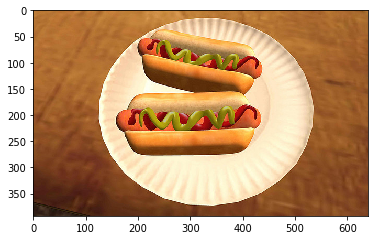

In [168]:
image = cv2.imread("MSO/img/COCO_COCO_train2014_000000052494.jpg")
b,g,r = cv2.split(image)       # get b,g,r
image = cv2.merge([r,g,b]) 
%matplotlib inline
plt.pyplot.imshow(image)
im = cv2.cvtColor(image,cv2.COLOR_BGR2Lab)
i_im = cv2.integral(im)
print(i_im.shape)

196
98
49


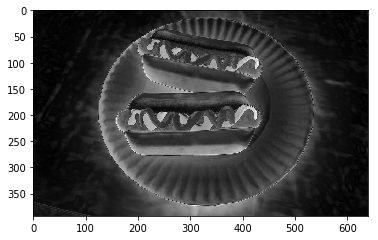

In [169]:
M = mean_saliency(im)
plt.pyplot.imshow(M, cmap = 'gray')

In [170]:
V, region_idxes = saliency_means_per_region(im, 2)

196
98
49


In [171]:
seg_image = segmented_image(image, V, 90 , region_idxes)

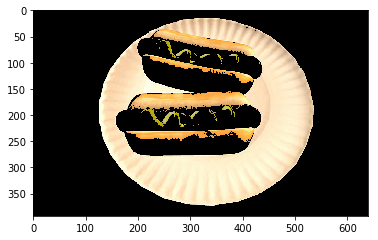

In [172]:
plt.pyplot.imshow(seg_image)

In [173]:
print V

[ 80.837864   133.50200314]


In [174]:
print(seg_image)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
